# Autoencoder CIFAR-10 Training and Experimentation

This notebook demonstrates training Autoencoder model on the CIFAR-10 dataset using a modular training pipeline implemented in PyTorch Lightning.


In [1]:
!git clone https://github.com/Reennon/gen-ai-cv-lab-1.git
%cd gen-ai-cv-lab-1

Cloning into 'gen-ai-cv-lab-1'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 153 (delta 53), reused 122 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (153/153), 161.27 KiB | 5.38 MiB/s, done.
Resolving deltas: 100% (53/53), done.
/content/gen-ai-cv-lab-1


In [2]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.4 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144555 sha256=a3d499ba647cba811c1464dda6fd67b2c6d5d1bf2b8c3ac0beaf882cc4bab1c4
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.0
    Uninstalling matplotlib-3.8.0:
      Successfully uninstalled matplotlib-3.8.0


In [3]:
!git pull

Already up to date.


In [4]:
import os
import dotenv
import wandb
import torch

from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import userdata

from src.visualization.base_visualizer import BaseVisualizer
from src.training.trainer import train_model
from src.models.autoencoder import Autoencoder


In [5]:
os.environ["WANDB_KEY"] = userdata.get("wandb_key")
!echo $WANDB_KEY >> .env

In [6]:
dotenv.load_dotenv()

True

In [7]:
parameters = OmegaConf.load("./params/autoencoder.yml")
wandb.login(key=os.environ["WANDB_KEY"])

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
wandb_project_name = "cifar-10-autoencoder"
device = "gpu"

In [9]:
# Define data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:04<00:00, 34.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [10]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(torch.min(images), torch.max(images))

tensor(-1.) tensor(1.)


In [11]:
images.shape

torch.Size([64, 3, 32, 32])

In [12]:
hparams = parameters.hyperparameters

In [17]:
# Edit hparams dict here as experiemnt, wandb will log the difference
hparams["lr"] = 1e-4
hparams["epochs"] = 20
hparams["latent_dim"] = 32

parameters.run_parameters.experiment_name = f"autoencoder-poly-scheduler-{hparams['latent_dim']}-lr-{hparams['lr']}-epochs-{hparams['epochs']}"

dict(hparams)

{'lr': 0.0001,
 'epochs': 30,
 'latent_dim': 32,
 'scheduler': {'type': 'PolynomialLR', 'params': {'total_iters': 20, 'power': 1.0}},
 'optimizer': {'type': 'Adam'}}

In [18]:
wandb.finish()

epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇████
learning_rate,█▇▇▆▆▅▅▄▄▃▃▂▂▁
train_loss,▄▅▆▄▃▄▅▆▁▇▆▄▅▆▅▃▇▄▅▃▃▅▄▅█▅▆▇▅▅▇▄▆▆▅▅█▇▄▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇████
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
learning_rate,0.00017
train_loss,0.22157
trainer/global_step,11099
val_loss,0.25464


In [19]:
# Train the Autoencoder
model = train_model(Autoencoder, parameters, train_loader, val_loader, wandb_project_name)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 789 K  | train
1 | decoder | Sequential | 793 K  | train
-----------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.335     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [20]:
# Visualize metrics from wandb
from IPython.display import display
wandb_url = wandb.run.get_url()
display(f"Wandb Dashboard: {wandb_url}")


'Wandb Dashboard: https://wandb.ai/rkovalchuk/cifar-10-autoencoder/runs/xyvdemos'

In [21]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
learning_rate,██▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇█▄▃▂▃▂▂▃▃▃▃▃▂▂▂▂▃▂▃▂▂▁▄▂▂▃▁▄▃▂▁▂▂▃▃▃▄▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇█████
val_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,29
learning_rate,0
train_loss,0.14935
trainer/global_step,23459
val_loss,0.15723


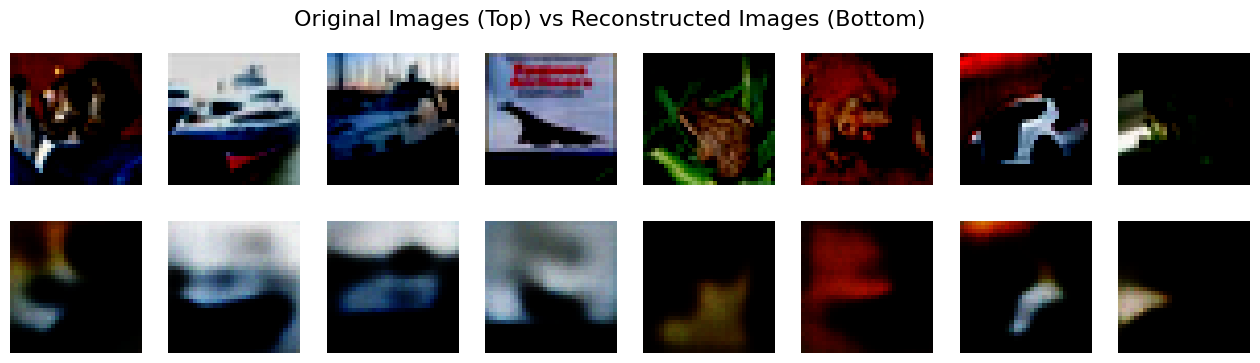

In [22]:
# Load the model
model.eval()

# Visualize original and reconstructed images
visualizer = BaseVisualizer(model, val_loader)
visualizer.visualize_reconstructions()